База с лекции.
Взят облегченй датасет.

In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

### Загрузим датасет

In [ ]:
# загрузим датасет со своего Google Drive

# предварительно необходимо скачать датасет с kaggle: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
# создать zip-архивы из папок simpsons_dataset и kaggle_simpson_testset
# и загрузить на свой google drive в папку netology_dl_sem

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir -p data

#!cp drive/MyDrive/netology_dl_sem/test.zip data/
#!cp drive/MyDrive/netology_dl_sem/train.zip data/

#!unzip -o -qq data/test.zip -d data/
#!unzip -o -qq data/train.zip -d data/
#!rm -rf data/simpsons_dataset/simpsons_dataset

In [ ]:
!pip install pyunpack
!pip install patool

from pyunpack import Archive
Archive('/content/drive/MyDrive/netology_dl_sem/test.7z').extractall('data/')
Archive('/content/drive/MyDrive/netology_dl_sem/train.7z').extractall('data/')

Все данные теперь находятся в папке `data`.

Тестовые данные (`kaggle_simpson_testset/`) сегодня не пригодятся.

Структура трейн данных (`simpsons_dataset/`) следующая:


 \\
-- class_name_0 \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_n \\
... \\
-- class_name_k \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_m \\


Т.е. название папки -- имя класса (персонажа из Симпсонов), изображения в ней относятся к этому классу.

In [ ]:

# разделим картинки на train и val в отношении 70 на 30 для каждого класса
# почему-то распаковка идет 2 раза. Внутри папки simpsons_dataset есть еще папка такая же. поэтому путь прописываю 2 раза.
data_dir = "data/simpsons_dataset/"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)


Изображений в train: 1495
Изображений в val: 641


В случае описанного выше строения хранящихся данных для создания датасета очень удобен `ImageFolder`.

Хоть авторы библиотеки это и не задумывали, но аргумент `is_valid_file` нам пригодился для разбиения на `train` и `val`.

In [ ]:
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)


Изображений в train: 1495
Изображений в val: 641


In [ ]:
input_size = 224
# в трэине мы преобразуем картинки чтобы умножить признаки
train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),# ранидомное изменение цветов
    transforms.RandomAffine(5),# афинное прреобразование
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 1495
    Root location: data/simpsons_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ColorJitter(brightness=(0.09999999999999998, 1.9), contrast=(0.09999999999999998, 1.9), saturation=(0.09999999999999998, 1.9), hue=None)
               RandomAffine(degrees=[-5.0, 5.0])
               ToTensor()
           )

In [ ]:
val_dataset

Dataset ImageFolder
    Number of datapoints: 641
    Root location: data/simpsons_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [ ]:
train_files_path[0]

'data/simpsons_dataset/chief_wiggum/pic_0594.jpg'

In [ ]:
os.path.basename(train_files_path[0])

'pic_0594.jpg'

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [ ]:
train_dataset.classes

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers']

Посмотрим на изображения из `val` и `train`

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=100)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

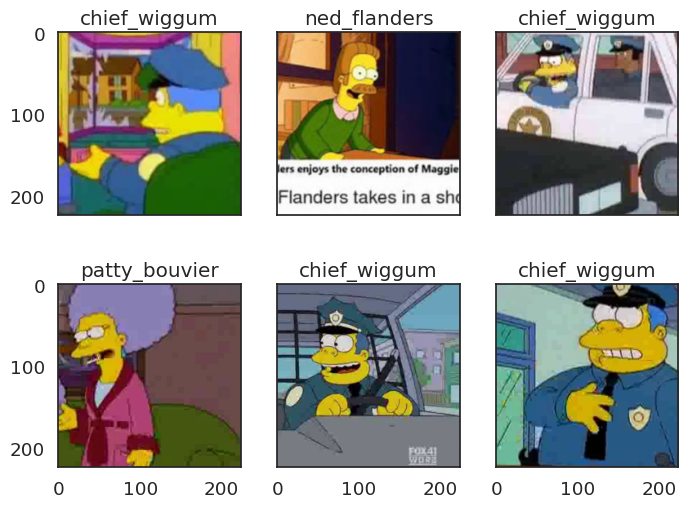

In [ ]:
show_images(val_dataset)

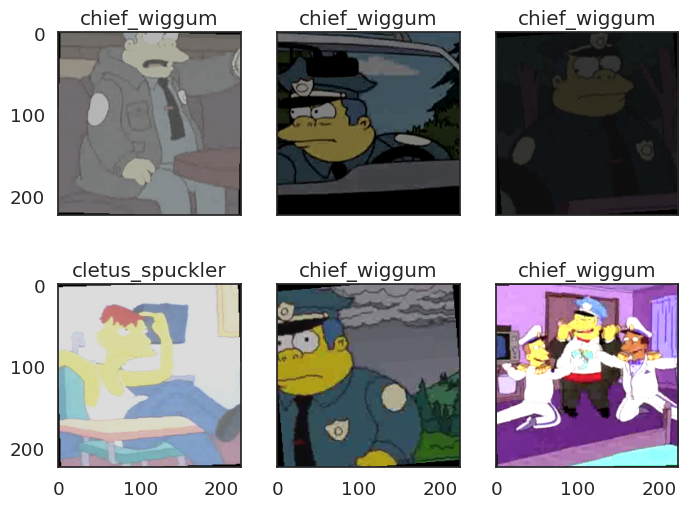

In [ ]:
show_images(train_dataset)

Видно, что картинки из `train` выглядят немного изменёнными по сравнению с `val`. Опишем по пунктам, почему так происходит.

1. К `train` применялись дополнительные аугментации `ColorJitter` и `RandomAffine`, чтобы увеличить размер датасета и обобщающую способность сети.
2. К `val` никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.

**Создадим DataLoader-ы и функции для обучения**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
from torchvision.models import resnet18

Обучим `Resnet18` с нуля

Epoch 20 of 20 took 18.599s
  training loss (in-iteration): 	2.310129
  validation loss (in-iteration): 	2.393464
  training accuracy: 			47.18 %
  validation accuracy: 			43.32 %


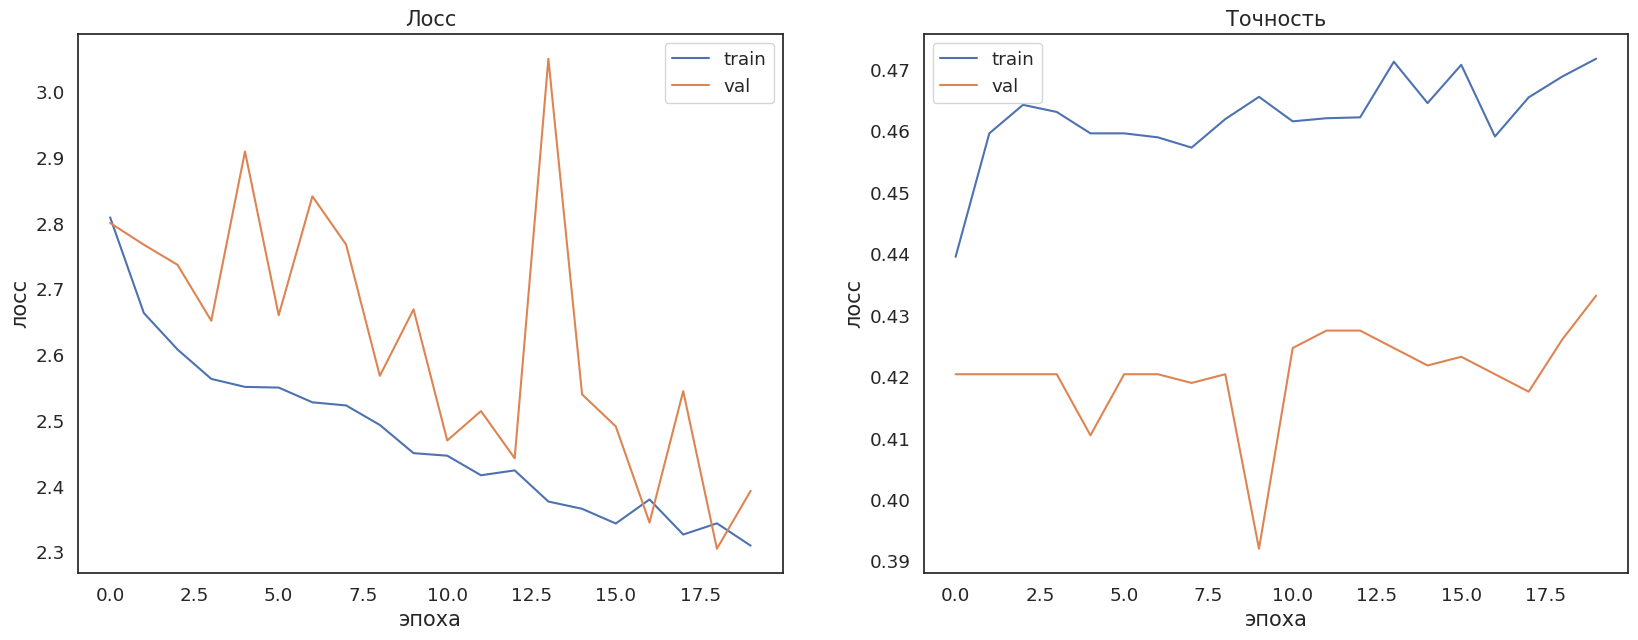

In [ ]:
model = resnet18(pretrained=False) #нам не нужны предобученные веса
model.fc = nn.Linear(512, 42) # берем и замен-м выходной слой. У нас 42 класса
model = model.to(device) # перемещаем на gpu

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=20
)

Будем использовать сеть как `Feature Extractor`

Epoch 20 of 20 took 16.607s
  training loss (in-iteration): 	1.835500
  validation loss (in-iteration): 	1.988319
  training accuracy: 			55.45 %
  validation accuracy: 			48.30 %


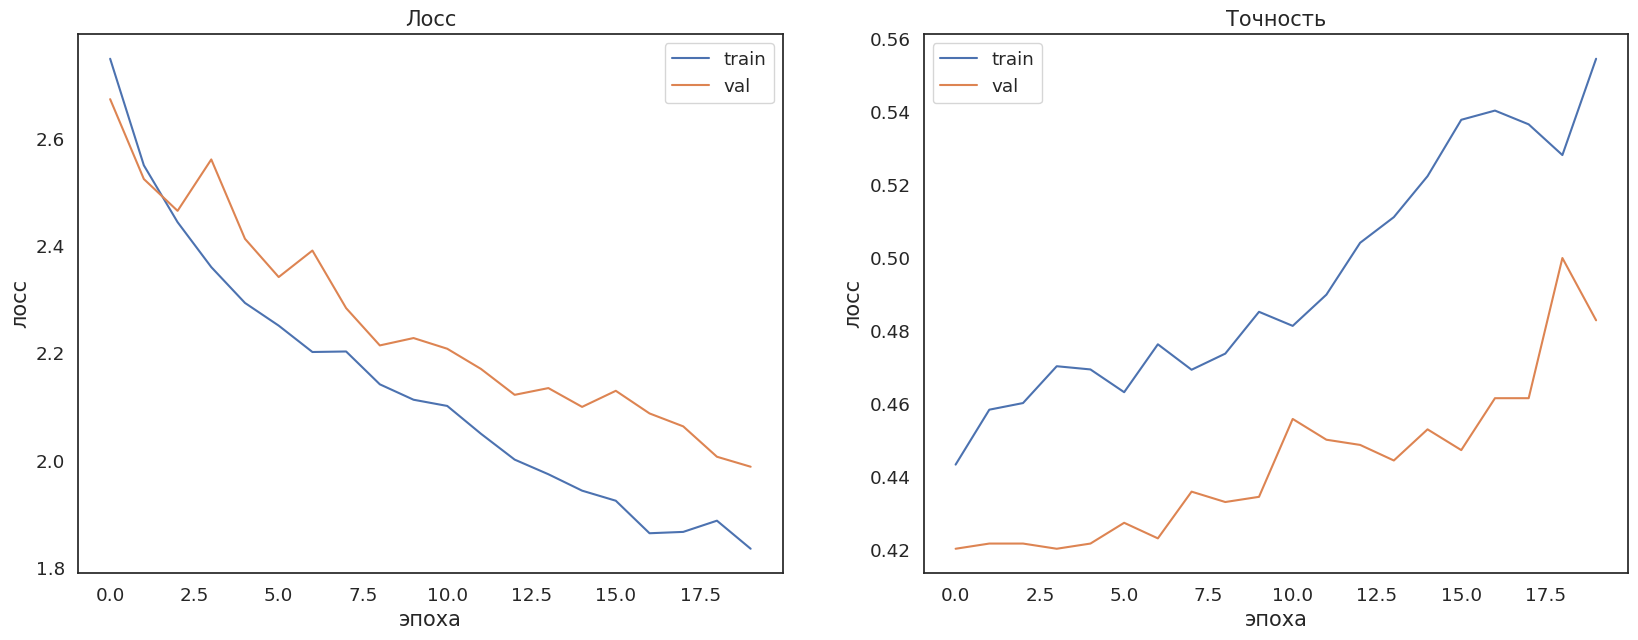

In [ ]:
# зайдем с другой стороны. Возбмем предобученную сеть

# возьмём предобученную сеть
fe_model = resnet18(pretrained=True) # предобуученную

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42) # поучаем 42 канала на выходе
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=20
)

Будем использовать как `FineTuning`

Epoch 20 of 20 took 18.759s
  training loss (in-iteration): 	0.314908
  validation loss (in-iteration): 	0.736635
  training accuracy: 			94.31 %
  validation accuracy: 			83.66 %


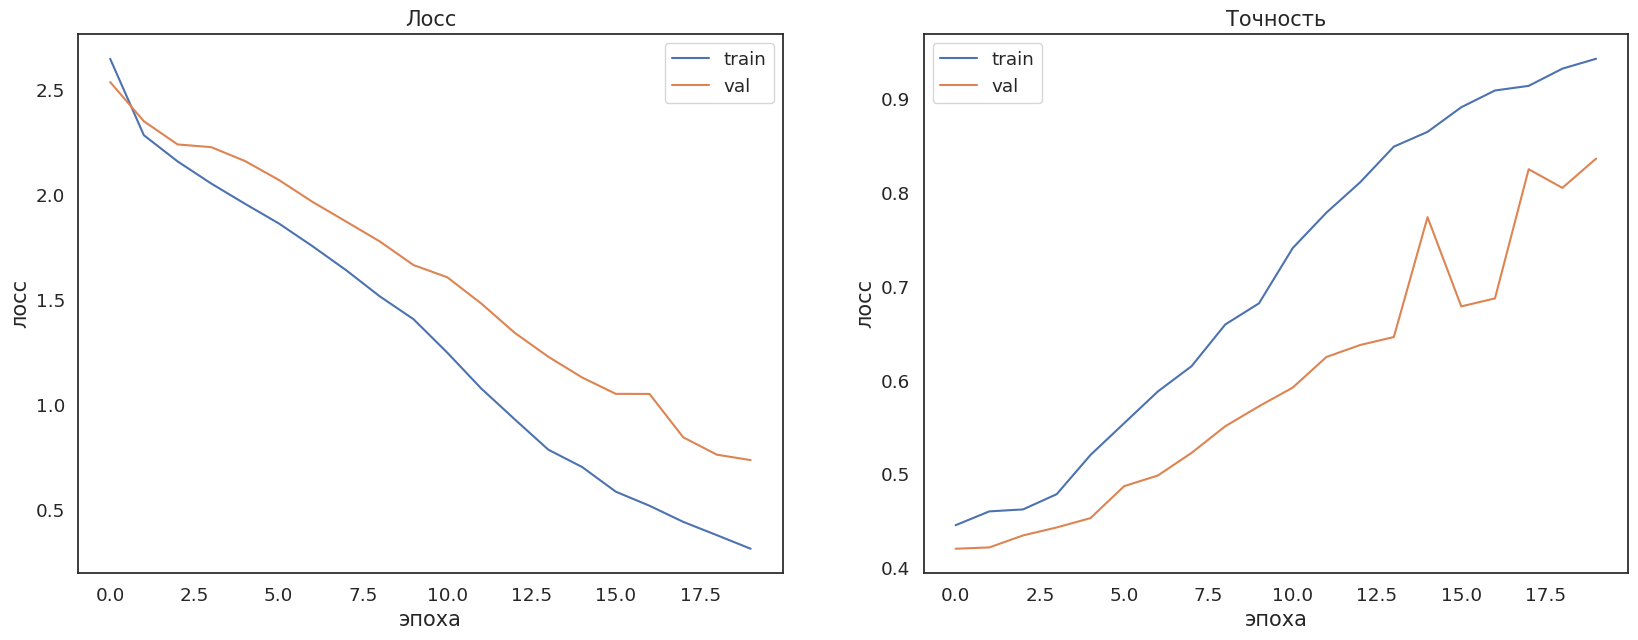

In [ ]:
# вариант 3 используем предобученную сеть и добавим еще слои

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=20
)

Почему в данном случае обучение с нуля дало худший результат, а fine tuning -- наилучший?

**Документация по шедулерам**

https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.


In [ ]:
from torch.optim.lr_scheduler import ExponentialLR


def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0



        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)
        scheduler = ExponentialLR(optimizer, gamma=0.9)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            scheduler.step() # добавили шедулер
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 20 of 20 took 19.494s
  training loss (in-iteration): 	2.578164
  validation loss (in-iteration): 	2.749717
  training accuracy: 			46.20 %
  validation accuracy: 			42.05 %


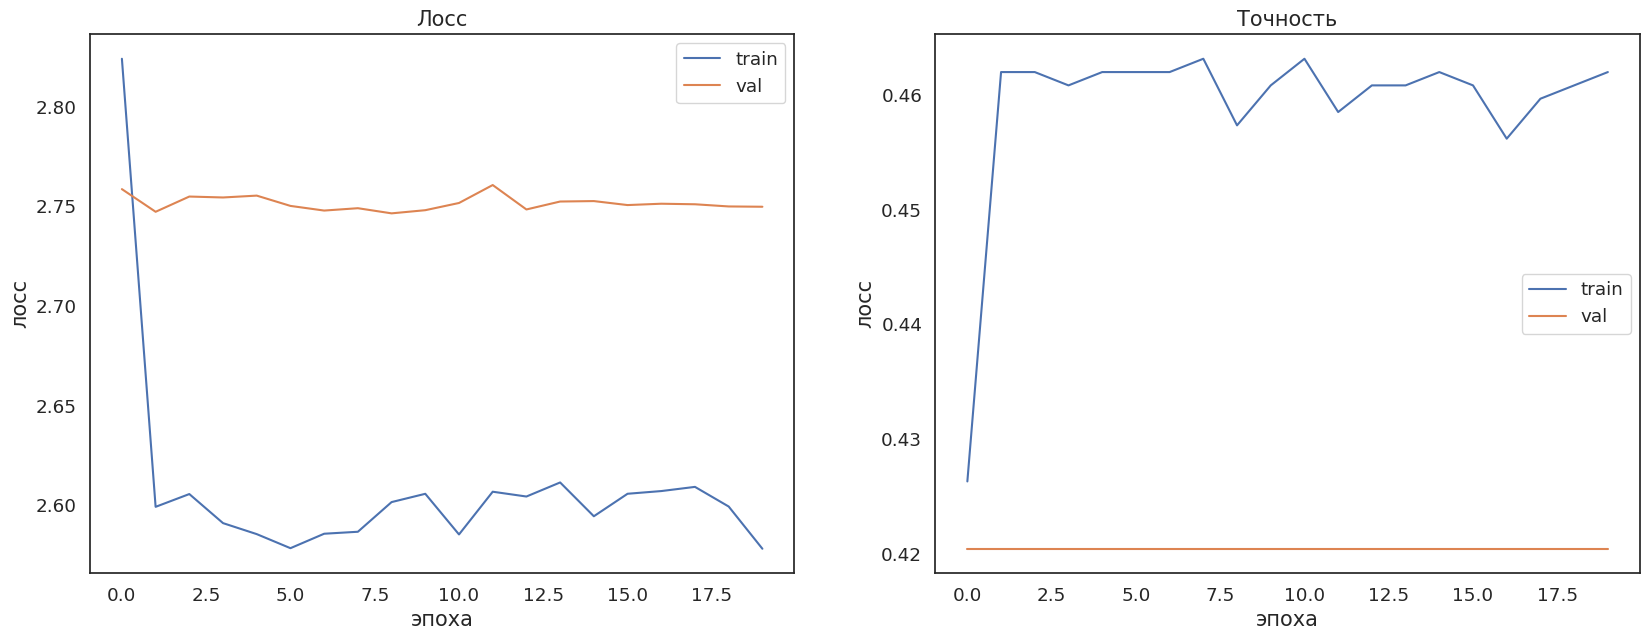

In [ ]:
# Используем базовый вариант 3 с лучшей точностью.

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=20
)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0



        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)
        scheduler = ReduceLROnPlateau(optimizer, 'min')

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            scheduler.step(loss) # добавили шедулер
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 20 of 20 took 20.510s
  training loss (in-iteration): 	2.052574
  validation loss (in-iteration): 	2.248034
  training accuracy: 			47.75 %
  validation accuracy: 			42.47 %


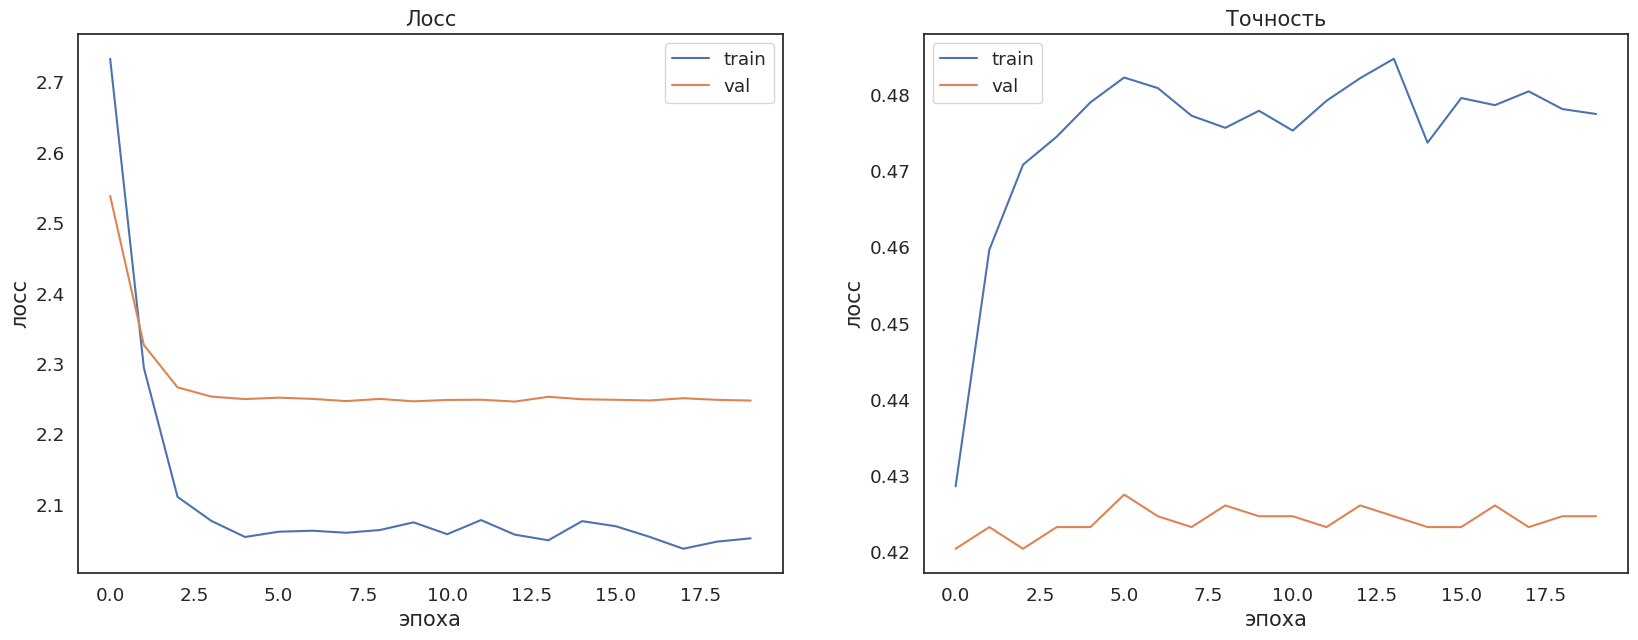

In [ ]:
# Используем базовый вариант 3 с лучшей точностью.

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=20
)

Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.


In [ ]:
# сильно изменим цвета
input_size = 224
# в трэине мы преобразуем картинки чтобы умножить признаки
train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1, hue=0.5),# ранидомное изменение цветов
    transforms.RandomAffine(5),# афинное прреобразование
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

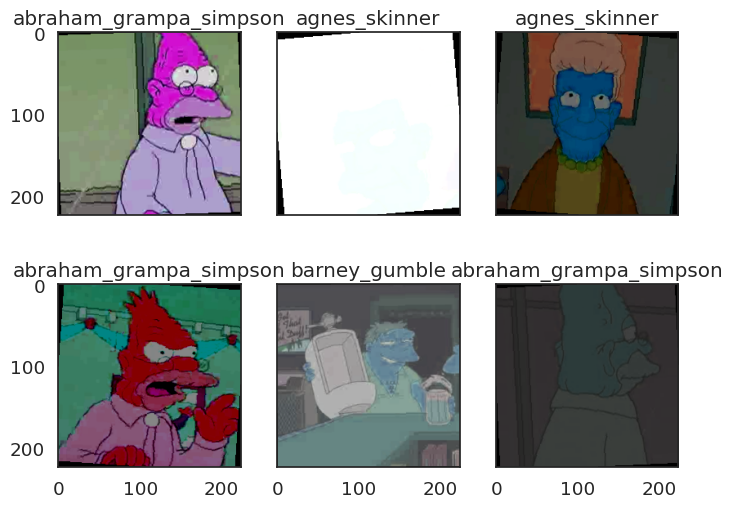

In [ ]:
show_images(train_dataset)

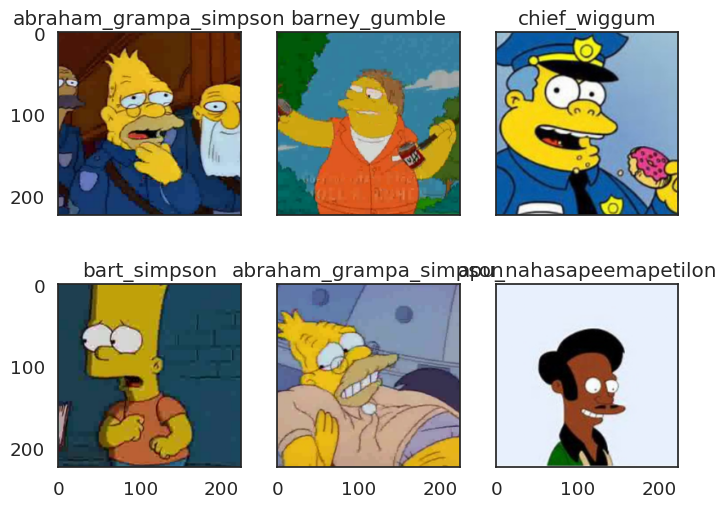

In [ ]:
show_images(val_dataset)

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 20 of 20 took 26.791s
  training loss (in-iteration): 	0.718529
  validation loss (in-iteration): 	1.451500
  training accuracy: 			84.35 %
  validation accuracy: 			61.65 %


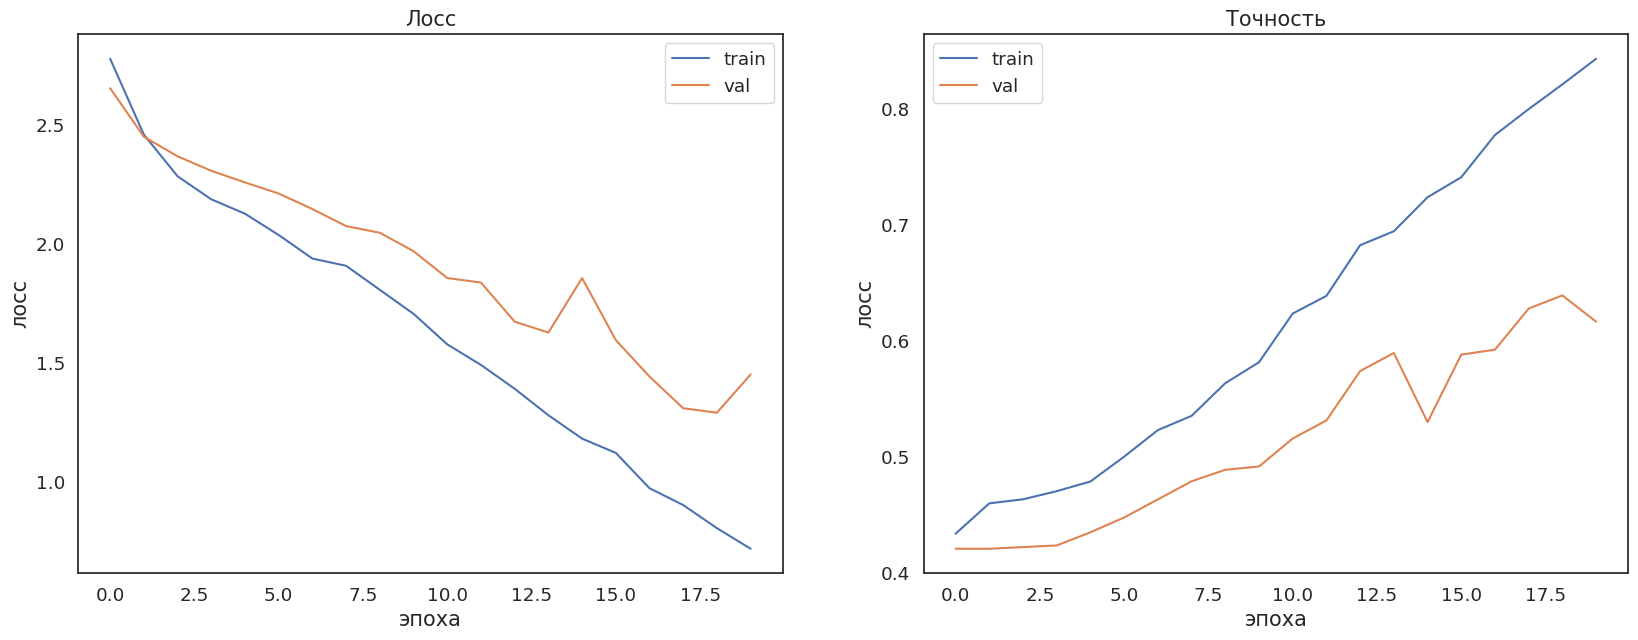

In [ ]:
# Используем базовый вариант 3 с лучшей точностью.

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=20
)

Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.

Epoch 20 of 20 took 46.399s
  training loss (in-iteration): 	0.028479
  validation loss (in-iteration): 	0.669668
  training accuracy: 			99.15 %
  validation accuracy: 			85.94 %


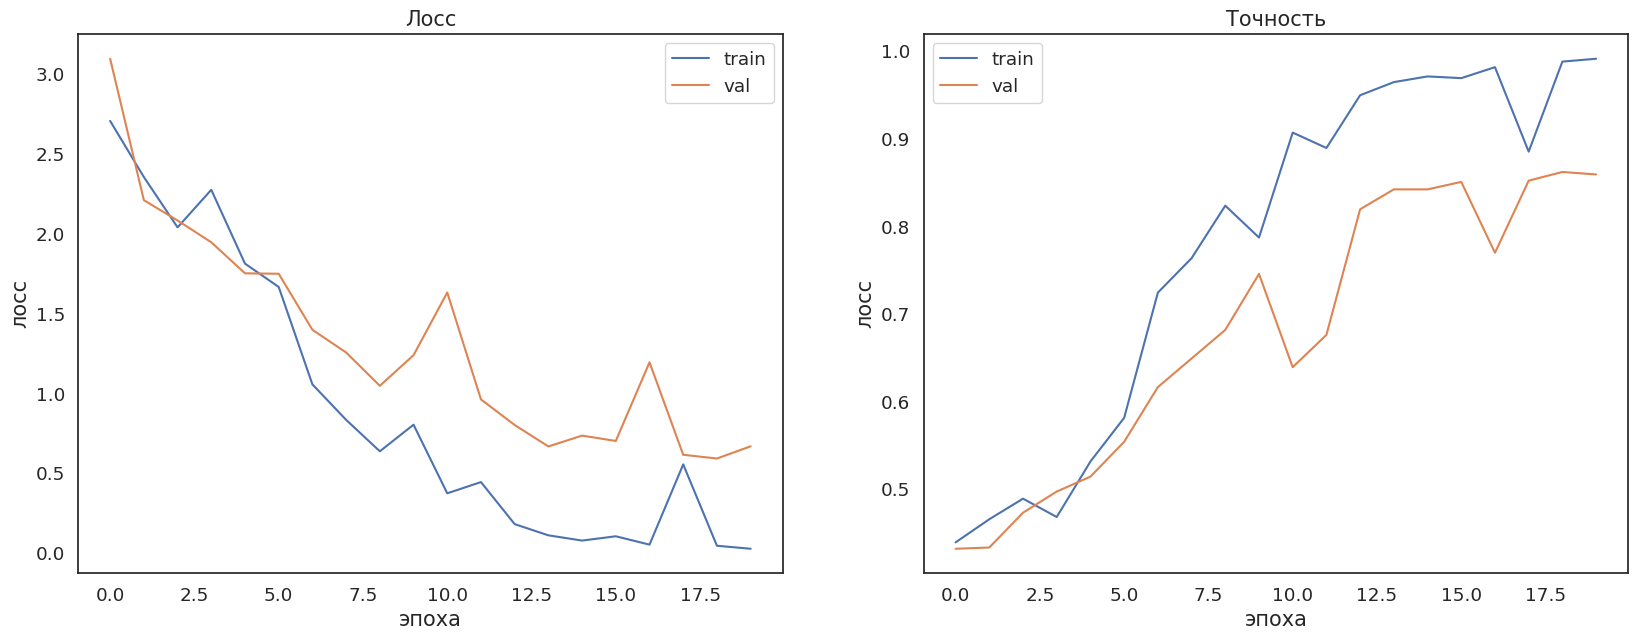

In [ ]:
# возьмем предобученную сеть.
import torch
import torch.nn as nn
from torchvision import models

model = models.vgg19(weights='IMAGENET1K_V1') #предобученная модель
model.classifier[6] = nn.Linear(4096, 42)  # 42 класса
#model = model.to(device) # перемещаем на gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)




criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=20
)

Выводы: за базовую версию взята 3 модель с лекции с дообучением.
  Точность
 training accuracy: 			94.31 %
validation accuracy: 			83.66 %


Используя ExponentialLR шелдулер получаем точность
 raining accuracy: 			46.20 %
  validation accuracy: 			42.05 %

 Используя ReduceLROnPlateau шелдулер получаем точность
   training accuracy: 			47.75 %
  validation accuracy: 			42.47 %

  Аугментации удалось уменьшить до    training accuracy: 			84.35 %
  validation accuracy: 			61.65 %
  На валидационой выборке снижение точности более 20%


  Используя  предобученную сеть VGG точность получится
  training accuracy: 			99.15 %
  validation accuracy: 			85.94 %

  Самая высокая точность у VGG, но потери выходят на пллато, а это значит, что скоро будет переобучение.